<a href="https://colab.research.google.com/github/IDeal7/ML/blob/master/study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


170500096/170498071 [==============================] - 13s 0us/step
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 533us/step - loss: 2.1838 - accuracy: 0.1667 - val_loss: 2.1186 - val_accuracy: 0.2153
Epoch 2/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.6422 - accuracy: 0.3847 - val_loss: 1.8207 - val_accuracy: 0.3397
Epoch 3/50
50000/50000 [==============================] - 14s 272us/step - loss: 1.3763 - accuracy: 0.4948 - val_loss: 1.6720 - val_accuracy: 0.3926
Epoch 4/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.1834 - accuracy: 0.5699 - val_loss: 1.5633 - val_accuracy: 0.4487
Epoch 5/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.0229 - accuracy: 0.6342 - val_loss: 1.4752 - val_accuracy: 0.4848
Epoch 6/50
50000/50000 [==============================] - 14s 272us/step - loss: 0.8848 - accuracy: 0.6862 - val_loss: 1.4154 - val_accur

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 10s 204us/step - loss: 2.2771 - accuracy: 0.4485
Epoch 3/10
50000/50000 [==============================] - 10s 206us/step - loss: 2.2729 - accuracy: 0.5414
Epoch 4/10
50000/50000 [==============================] - 10s 205us/step - loss: 2.2700 - accuracy: 0.6148
Epoch 5/10
50000/50000 [==============================] - 10s 204us/step - loss: 2.2684 - accuracy: 0.6614
Epoch 6/10
50000/50000 [==============================] - 10s 203us/step - loss: 2.2672 - accuracy: 0.6986
Epoch 7/10
50000/50000 [==============================] - 10s 202us/step - loss: 2.2663 - accuracy: 0.7319
Epoch 8/10
50000/50000 [==============================] - 10s 203us/step - loss: 2.2657 - accuracy: 0.7562
Epoch 9/10
50000/50000 [==============================] - 10s 203us/step - loss: 2.2652 - accuracy: 0.7739
Epoch 10/10
50000/50000 [==============================] - 10s 203us/step - loss: 2.2648 - accuracy: 0.7862
student1 Test loss: 0.8948976439476013
student1

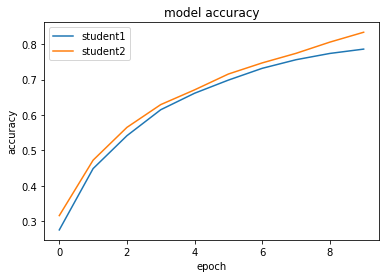

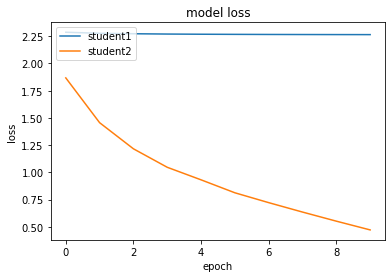

'\nhist_x = np.arange(len(hist_list))\nx_label = ["teacher loss","teacher acc", "student1 loss","student1 acc", "student2 loss","student2 acc"]\nplt.bar(hist_x, hist_list)\nplt.xticks(hist_x, x_label)\nplt.xlabel("score")\nplt.show()\n'

In [1]:
from keras.datasets import mnist, fashion_mnist, cifar100, cifar10
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
import keras.backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import activations
from keras import utils

np.random.seed(0)

dataset = cifar10
dataset_name = "cifar10"
img_rows = 32
img_cols = 32
channels = 3
T = 10.0  # T-value
num_classes = 10
result_list = []
input_shape = (img_rows, img_cols, channels)
earlystopping = EarlyStopping(monitor="val_loss", patience=3)


def softer_softmax(x, axis=-1):
    ndim = K.ndim(x)
    if ndim == 1:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
    elif ndim == 2:
        return K.softmax(x / T)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D. '
                         'Received input: %s' % x)


def softmax2softer_softmax(x):
    y = []

    for i in range(len(x)):
        distilled_x = []  # x/T = 분자
        for j in range(len(x[0])):
            distilled_x.append(np.log((x[i][j]) * sum(x[i]))/T)  # 적용된 소프트맥스를 역연산하여 원래의 확률을 구하고, T 로 나누어 정규화

        softer_x = []  # softer_softmax가 적용된 x
        for j in range(len(x[0])):
            softer_x.append(np.exp(distilled_x[j])/sum(np.exp(distilled_x)))

        y.append(softer_x)  # 분자.분모
    y = np.array(y)
    return y


def teacher_model():
    (x_train, y_train), (x_test, y_test) = dataset.load_data()

    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist = model.fit(x_train, y_train,
                     batch_size=512,
                     epochs=50,
                     verbose=1,
                     validation_data=(x_test, y_test),
                     callbacks=[earlystopping])

    model.save("{}_teacher.h5".format(dataset_name))


teacher_model()


# distilled model
def student_model1():
    (x_train, y_train), (x_test, y_test) = dataset.load_data()

    #    index = np.where(y_train == 1)  # 라벨이 1인것들은 모두 삭제
    #    index2 = np.where(y_test == 1)

    #    x_train = np.delete(x_train, index, axis=0)
    #    y_train = np.delete(y_train, index, axis=0)

    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation=softer_softmax))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("{}_teacher.h5".format(dataset_name))
    teacher_model = load_model("{}_teacher.h5".format(dataset_name))  # 기존의 y대신 teacher 모델로 뽑은 soft label 사용
    soft_pred = teacher_model.predict(x_train)
    soft_labels = softmax2softer_softmax(soft_pred)

    hist1 = model.fit(x_train, soft_labels,
                      epochs=10,
                      batch_size=512,
                      verbose=1,
                      callbacks=[earlystopping])

    model.layers[-1].activation = activations.softmax
    model.save("{}_student1.h5".format(dataset_name))
    model = load_model("{}_student1.h5".format(dataset_name))

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('student1 Test loss:', test_loss)
    print('student1 Test accuracy:', test_acc)

    return hist1


hist1 = student_model1()


def student_model2():
    (x_train, y_train), (x_test, y_test) = dataset.load_data()

    #    index = np.where(y_train == 1)  # 라벨이 1인것들은 모두 삭제
    #    index2 = np.where(y_test == 1)

    #    x_train = np.delete(x_train, index, axis=0)
    #    y_train = np.delete(y_train, index, axis=0)

    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    hist2 = model.fit(x_train, y_train,
                      epochs=10,
                      batch_size=512,
                      verbose=1,
                      callbacks=[earlystopping])

    model.save("{}_student2.h5".format(dataset_name))

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print("student2 Test loss:", test_loss)
    print('student2 Test accuracy:', test_acc)

    return hist2


hist2 = student_model2()

plt.plot(hist1.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['student1', 'student2'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['student1', 'student2'], loc='upper left')
plt.show()

# print(result_list)
'''
hist_x = np.arange(len(hist_list))
x_label = ["teacher loss","teacher acc", "student1 loss","student1 acc", "student2 loss","student2 acc"]
plt.bar(hist_x, hist_list)
plt.xticks(hist_x, x_label)
plt.xlabel("score")
plt.show()
'''